In [1]:
from qiskit_aer.primitives import Estimator
import numpy as np
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SLSQP, COBYLA

In [2]:
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

dist = 1.09
angle = 109.5/180*np.pi
aac = np.cos(angle/2)
aas = np.sin(angle/2)

zz = np.sqrt(np.square(1.09*float(aac))-np.square(1.09*float(aas))/3)
xx = np.sqrt(np.square(dist)-np.square(zz))


molecule = MoleculeInfo(
        # Coordinates in Angstrom
    symbols=["C", "H", "H", "H", "H"],
    coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0], [-zz, xx, 0.0], 
            [-zz, -xx/2, -xx*np.sqrt(3)/2], [-zz, -xx/2, xx*np.sqrt(3)/2]),
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

In [3]:
driver = PySCFDriver.from_molecule(molecule)
properties = driver.run()

In [4]:
problem = FreezeCoreTransformer(
    freeze_core=True, remove_orbitals=[0, 0]
).transform(properties)

num_particles = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals

mapper = ParityMapper(num_particles=num_particles)
qubit_op = mapper.map(problem.second_q_ops()[0])

In [5]:
qubit_op.num_qubits

14

In [6]:
import torch
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np

from qiskit.primitives import Estimator
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import EfficientSU2

In [7]:
#######Parameterized circuit

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

# params = [Parameter("theta"), Parameter("phi"), Parameter("lam"), 
#           Parameter("theta1"), Parameter("phi1"), Parameter("lam1")]
params = []
for i in range(0, 14):
    params.append(Parameter(f"theta{i}"))
    params.append(Parameter(f"phi{i}"))
    params.append(Parameter(f"lam{i}"))



qr = QuantumRegister(14, name="q")
circ = QuantumCircuit(qr)

for iii in range(0,14):
    circ.u(params[3*iii], params[3*iii+1], params[3*iii+2], qr[iii])
# circ.u(params[3], params[4], params[5], qr[1])
# circ.cx(0,1)
 
print(circ)

       ┌─────────────────────┐  
 q_0: ─┤ U(theta0,phi0,lam0) ├──
       ├─────────────────────┤  
 q_1: ─┤ U(theta1,phi1,lam1) ├──
       ├─────────────────────┤  
 q_2: ─┤ U(theta2,phi2,lam2) ├──
       ├─────────────────────┤  
 q_3: ─┤ U(theta3,phi3,lam3) ├──
       ├─────────────────────┤  
 q_4: ─┤ U(theta4,phi4,lam4) ├──
       ├─────────────────────┤  
 q_5: ─┤ U(theta5,phi5,lam5) ├──
       ├─────────────────────┤  
 q_6: ─┤ U(theta6,phi6,lam6) ├──
       ├─────────────────────┤  
 q_7: ─┤ U(theta7,phi7,lam7) ├──
       ├─────────────────────┤  
 q_8: ─┤ U(theta8,phi8,lam8) ├──
       ├─────────────────────┤  
 q_9: ─┤ U(theta9,phi9,lam9) ├──
      ┌┴─────────────────────┴─┐
q_10: ┤ U(theta10,phi10,lam10) ├
      ├────────────────────────┤
q_11: ┤ U(theta11,phi11,lam11) ├
      ├────────────────────────┤
q_12: ┤ U(theta12,phi12,lam12) ├
      ├────────────────────────┤
q_13: ┤ U(theta13,phi13,lam13) ├
      └────────────────────────┘


In [8]:
estimator = Estimator()
optimizers = [COBYLA(maxiter=0)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 0
    
#     ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, reps=1, entanglement='linear', insert_barriers=True)
    ansatz = circ
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    k = np.random.rand(42)*np.pi*2 #pick random points
    
    vqe = VQE(estimator, ansatz, optimizer, initial_point = k, callback=store_intermediate_result)
    
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    
    print(result)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimizer: COBYLA        {   'aux_operators_evaluated': None,
    'cost_function_evals': 1,
    'eigenvalue': -13.258262966538648,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x150b99ee7910>,
    'optimal_parameters': {   Parameter(theta0): 0.9954327360800577,
                              Parameter(phi0): 3.117640421919589,
                              Parameter(lam0): 2.3167572879862415,
                              Parameter(theta1): 4.27743445345756,
                              Parameter(phi1): 3.4209509321689056,
                              Parameter(lam1): 3.1860148636796337,
                              Parameter(theta2): 1.3109526844660522,
                              Parameter(phi2): 5.506140444105925,
                              Parameter(lam2): 5.688798969868866,
                              Parameter(theta3): 5.18259676966998,
                              Parameter(phi3): 0.6963450010602035,
                              Param

In [9]:
#########################################################################ML part
train_X = torch.rand(5, 42)
optimizers = [COBYLA(maxiter=0)]

In [10]:
Y = []

for i in range(0,5,1):
    res = VQE(estimator, ansatz, optimizer, initial_point = train_X[i]*2*np.pi, callback=store_intermediate_result)
    res1 = -res.compute_minimum_eigenvalue(operator=qubit_op).eigenvalue
    Y.append(res1)
    #Y += 0.1 * torch.rand_like(Y)

In [11]:
from gpytorch.kernels import spectral_mixture_kernel
from gpytorch.kernels import SpectralMixtureKernel
from gpytorch.kernels import PeriodicKernel
from sklearn.preprocessing import StandardScaler

Y= np.array(Y)




train_Y = (Y - Y.mean()) / Y.std()
train_Y = torch.from_numpy(train_Y)
train_Y = train_Y.view(-1,1)
train_Y = train_Y.float()
train_Yvar = torch.full_like(train_Y, 0.05)
# train_Yvar = torch.clamp_min(train_Yvar, 0.0001)


# num_mixtures = 4
# input_dim = 42
# smk_kernel = SpectralMixtureKernel(num_mixtures=num_mixtures, ard_num_dims=input_dim)
periodic_kernel = PeriodicKernel()

# model = FixedNoiseGP(train_X, train_Y, train_Yvar, covar_module=smk_kernel)
train_X = train_X.double()
train_Y = train_Y.double()
train_Yvar = train_Yvar.double()

model = FixedNoiseGP(train_X, train_Y, train_Yvar, covar_module=periodic_kernel)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

/home/xj54kovo/anaconda3/envs/newenv4/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [12]:
from botorch.acquisition.monte_carlo import qExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
# from botorch.acquisition.monte_carlo import MCSampler
from botorch.sampling import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler

sampler=SobolQMCNormalSampler(256)
# ei = qExpectedImprovement(model,best_f=train_Y.max(),maximize=True,sampler=sampler)

# ei = qEI = qExpectedImprovement(model, best_f=train_Y.max(), sampler=sampler,maximize=True)

qUCB = qUpperConfidenceBound(model, 0.9, sampler)

ei = qUCB

In [13]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(42), torch.ones(42)])

candidate, acq_value = optimize_acqf(
    ei, bounds=bounds, q=10, num_restarts=10, raw_samples=512,
)

In [14]:
loop = 100
Y_new = Y
# train_X_new = torch.cat([train_X, candidate], dim=0)
train_X_new = train_X
sampler=SobolQMCNormalSampler(256)


mm = []
ee = []
for ii in range(1,loop):
    train_X_new = torch.cat([train_X_new, candidate], dim=0)
    kk = 0
    
    while kk < 10:
        hh = 5+(ii-1)*10+kk
        res = VQE(estimator, ansatz, optimizer, initial_point = train_X_new[hh]*2*np.pi, callback=store_intermediate_result)
        new_data = -res.compute_minimum_eigenvalue(operator=qubit_op).eigenvalue
        print(new_data)
        ee.append(new_data)
        Y_new = np.append(Y_new, new_data)
    
        kk += 1

    mm.append(np.max(ee))   
    train_Y_new = (Y_new - Y_new.mean()) / Y_new.std()
    train_Y_new_num = torch.from_numpy(train_Y_new)
    train_Y_new_num = train_Y_new_num.view(-1,1)
    train_Y_new_num = train_Y_new_num.float()
    train_Y_new_num_var = torch.full_like(train_Y_new_num, 0.1)
#     train_Y_new_num_var = torch.clamp_min(train_Y_new_num_var, 0.0001)
    
    train_X_new = train_X_new.double()
    train_Y_new_num = train_Y_new_num.double()
    train_Y_new_num_var = train_Y_new_num_var.double()


    model = FixedNoiseGP(train_X_new, train_Y_new_num, train_Y_new_num_var, covar_module=periodic_kernel)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);
    
    
#     ei = qExpectedImprovement(model,best_f=train_Y.max(),sampler=sampler,maximize=True)
    sampler=SobolQMCNormalSampler(256)
    ei = qUpperConfidenceBound(model, 0.9, sampler)
    
    bounds = torch.stack([torch.zeros(42), torch.ones(42)])
    candidate, acq_value = optimize_acqf(
    ei, bounds=bounds, q=10, num_restarts=20, raw_samples=512)
     
#     print(candidate)

12.905263623939451
12.669494393042585
13.206419008242829
12.63955458529832
11.691900938499437
14.056769016585722
12.912918445830782
11.809542251743586
12.288312492383435
13.871448061805916


/home/xj54kovo/anaconda3/envs/newenv4/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


13.37839667277067
13.474919666336001
13.417049769203537
12.205203377105757
13.71621463489125
13.389065174507213
12.299745068243288
12.717319369529717
12.91965377224293
13.489044143751766


/home/xj54kovo/anaconda3/envs/newenv4/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


14.05308081408473
13.26419612201873
12.77940520666745
12.548677935389152
12.45729036972627
12.623638836734436
12.818903534569094
13.664056191875634
13.364595125547512
13.023099362057776


/home/xj54kovo/anaconda3/envs/newenv4/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


12.668092786000194
14.340684281804572
12.031618241012827
12.146746090897494
12.704369495516803
12.390488294128126
12.680712576051354
12.051980029144794
11.58715559360326
12.787100048577722


/home/xj54kovo/anaconda3/envs/newenv4/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


12.847435139000691
13.207559938523156
13.207251077253794
12.116015971115974
12.795397745182482
13.49661324453333
10.463274122871885
11.880128995209338
11.680558618155228
13.493684612168872
11.659810704153577
13.066102360396103
13.296321332096309
12.855947620887173
13.515982424531824
12.794748674183944
13.982421989747355
13.13293027338602
12.275542672424882
11.71872554372654
14.551050170471838
11.460490743403378
13.803655722659794
12.242178444245246
12.776614268984675
12.702970431652632
12.06536751549995
12.194994544298575
12.87836588441045
13.450505357488447
12.695523715703708
12.52052481512362
13.098241358872931
12.501858724980682
13.155509011485474
12.45836242446864
12.566332358265072
13.226054562337
12.566437271774571
12.953476405198485
12.529356394346275
14.441224972470462
12.383026103348579
13.82696472147598
12.452061025844863
12.992930998150989
12.43374385144963
13.223682857200783
13.40121564521358
13.264925206532203
12.881837647760758
12.355097002691743
12.845725395108765
13.717

11.658858876413426
13.127702553055391
13.089458864903778
12.611558336787148
13.281533387756667
13.183974539072539
13.249280919091728
13.402500993205324
13.543842329029921
12.818934807739462
13.437811220663228
12.933879620295379
12.628294206218259
13.209753822766311
12.326810074447591
12.1824229077345
12.541266451164523
12.959617959223356
12.945833028667243
12.435099595536956
12.449575078063862
13.31410396112956
12.599965647934255
14.405015243281607
12.849057657006837
12.441530569844268
12.123891666841113
13.710837411945187
12.915685234908626
12.859733048015078
12.6047489386418
13.652176381010642
13.3500036062439
13.652106846486705
11.936087454818516
11.630719468066326
13.539375626893046
13.708581470236602
11.360028417992607
13.467235940228871
12.100918683679279
13.494537346405256
12.234064769740721
13.364308137073943
13.486277873009058
12.055993780333239
11.973523838652069
13.125828686527916
13.311541557354996
12.320169011608646
11.978017275502223
12.674525685650035
12.917282652633522


12.943845787990492
13.438029300107559
12.947843024266708
13.211446882744372
13.579807538890693
12.015786379913829
12.572126284449519
13.064271701998333
11.326962820630348
12.966123067500128
12.498394172040191
13.604922427738666
13.1588371053836
12.368207071356055
12.838497307013178
13.230465963561132
12.873841501193596
12.933369891444826
12.730547713972532
13.472319874885475
13.464366392731634
13.215602773095577
12.78225910724309
13.48874612673656
12.09407799278981
12.990206064088751
12.56875267526475
13.719641331990482
12.848016740752325
13.349491921239235
13.646870183470975
12.810929600288937
13.245572269868783
13.554769043312863
12.625666118697644
13.923440951169713
13.288511901682893
13.796473935476277
12.760636371110024
12.792814024208628
12.902891141498671
13.566324792777431
13.913404916733379
12.239190283448874
13.413789313672943
13.469403422110403
11.847178288236194
12.306555883477944
10.419966113769949
12.356067927020783
13.603611900820479
14.082478972435771
12.035643205181422

In [17]:
mm

[14.056769016585722,
 14.056769016585722,
 14.056769016585722,
 14.340684281804572,
 14.340684281804572,
 14.340684281804572,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.551050170471838,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415825207,
 14.575414415

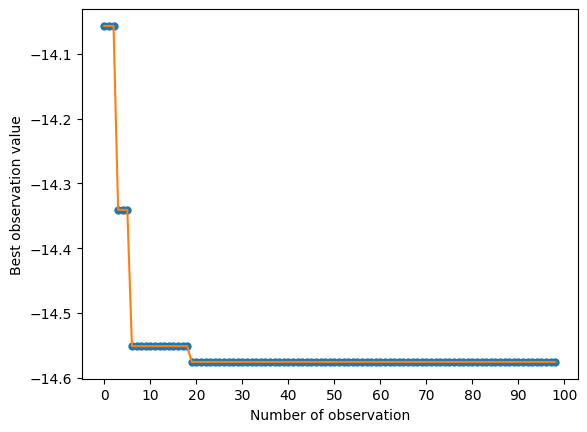

In [19]:


%matplotlib inline
import matplotlib.pyplot as plt
ll = [-1 * x for x in mm]
data = ll
fig, ax = plt.subplots()
tick = np.linspace(0,100,11)
# Plot the data as points
ax.plot(range(len(data)), data, '.', markersize=10, label='Data Points')

ax.plot(range(len(data)), data, '-', markersize=5, label='Data Line')

# Set x-axis and y-axis labels
ax.set_xlabel('Number of observation')
ax.set_ylabel('Best observation value')
plt.xticks(tick)
# Show the plot
plt.show()

